# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 1



**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

**WARNING**: There is web page scraping in this homework. It takes about 40 minutes. **Do not wait till the last minute** to do this homework.

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. There is an important CAVEAT to this. DO NOT run the web-page fetching cells again. (We have provided hints like `# DO NOT RERUN THIS CELL WHEN SUBMITTING` on some of the cells where we provide the code). Instead load your data structures from the JSON files we will ask you to save below. Otherwise you will be waiting for a long time. (Another reason to not wait until the last moment to submit.)

- Do not include your name in the notebook.

---

# Homework 1: Rihanna or Mariah?

Billboard Magazine puts out a top 100 list of "singles" every week. Information from this list, as well as that from music sales, radio, and other sources is used to determine a top-100 "singles" of the year list. A **single** is typically one song, but sometimes can be two songs which are on one "single" record.

In this homework you will: 

1. Scrape Wikipedia to obtain infprmation about the best singers and groups from each year (distinguishing between the two groups) as determined by the Billboard top 100 charts. You will have to clean this data. Along the way you will learn how to save data in json files to avoid repeated scraping. 
2. Scrape Wikipedia to obtain information on these singers. You will have to scrape the web pages, this time using a cache to guard against network timeouts (or your laptop going to sleep). You will again clean the data, and save it to a json file.
3. Use pandas to represent these two datasets and merge them.
4. Use the individual and merged datasets to visualize the performance of the artists and their songs. We have kept the amount of analysis limited here for reasons of time; but you might enjoy exploring music genres and other aspects of the music business you can find on these wikipedia pages at your own leisure.

You should have worked through Lab0 and Lab 1, and Lecture 2.  Lab 2 will help as well.

As usual, first we import the necessary libraries.  In particular, we use [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) to give us a nicer default color palette, with our plots being of large (`poster`) size and with a white-grid background. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests

## Q1. Scraping Wikipedia for Billboard Top 100.

In this question you will scrape Wikipedia for the Billboard's top 100 singles.

### Scraping Wikipedia for Billboard singles

We'll be using  [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/), and suggest that you use Python's built in `requests` library to fetch the web page.

#### 1.1 Parsing the Billboard Wikipedia page for 1970

Obtain the web page at http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970 using a HTTP GET request. From this web page we'll extract the top 100 singles and their rankings. Create a list of dictionaries, 100 of them to be precise, with entries like 

`{'url': '/wiki/Sugarloaf_(band)', 'ranking': 30, 'band_singer': 'Sugarloaf', 'title': 'Green-Eyed Lady'}`. 

If you look at that web page, you'll see a link for every song, from which you can get the `url` of the singer or band. We will use these links later to scrape information about the singer or band. From the listing we can also get the band or singer name `band_singer`, and `title` of the song.

*HINT: look for a table with class `wikitable`.*

In [3]:
import requests
from bs4 import BeautifulSoup
webpg = requests.get('http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970')
webpg.status_code
c = webpg.content
soup = BeautifulSoup(c,"lxml")
tables = soup.find_all('table',{'class':'wikitable'})
songs = []
ctr=0
for row in tables[0].find_all('tr'):
    if ctr != 0:
        cols = row.find_all('td')
        
        links = cols[2].find('a')
        if links != None:
            link = links.get('href')
        dct = {'band_singer':cols[2].text,'ranking' : int(cols[0].text) , 'title': cols[1].getText(),'url' : str(link)}
        songs.append(dct)
    ctr+=1
    
    
print(songs[2:4])

[{'band_singer': 'The Guess Who', 'ranking': 3, 'title': '"American Woman"', 'url': '/wiki/The_Guess_Who'}, {'band_singer': 'B.J. Thomas', 'ranking': 4, 'title': '"Raindrops Keep Fallin\' on My Head"', 'url': '/wiki/B.J._Thomas'}]



<font color='green'>In this section we parse through the 1970 singles, look for the wikitable, iterate through rows and then columns and find all the links of the artists. As you can see - our printed statement generates the expected result </font> 

You should get something similar to this (where songs is the aforementioned list):

```
songs[2:4]
```

```
[{'band_singer': 'The Guess Who',
  'ranking': 3,
  'title': '"American Woman"',
  'url': '/wiki/The_Guess_Who'},
 {'band_singer': 'B.J. Thomas',
  'ranking': 4,
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': '/wiki/B.J._Thomas'}]
```

#### 1.2 Generalize the previous: scrape Wikipedia from 1992 to 2014

By visiting the urls similar to the ones for 1970, we can obtain the billboard top 100 for the years 1992 to 2014. (We choose these later years rather than 1970 as you might find music from this era more interesting.) Download these using Python's `requests` module and store the text from those requests in a dictionary called `yearstext`. This dictionary ought to have as its keys the years (as integers from 1992 to 2014), and as values corresponding to these keys the text of the page being fetched.

You ought to sleep a second (look up `time.sleep` in Python) at the very least in-between fetching each web page: you do not want Wikipedia to think you are a marauding bot attempting to mount a denial-of-service attack.

*HINT: you might find `range` and string-interpolation useful to construct the URLs *.


In [4]:
yearstext = {}
for years in range(1992,2015):
    url = 'http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_' + str(years)
    webpg = requests.get(url)
    c = webpg.content
    yearstext[years] = c
    time.sleep(0.1)

<font color='green'> In this section we simply iterate over the years from 1992 to 2014 and pick up the contents of each webpage and store them in a dictionary</font> 

#### 1.3 Parse and Clean data 

Remember the code you wrote to get data from 1970 which produces a list of dictionaries, one corresponding to each single.  Now write a function `parse_year(the_year, yeartext_dict)` which takes the year, prints it out, gets the text for the year from the just created `yearstext` dictionary, and return a list of dictionaries for that year, with one dictionary for each single. Store this list in the variable `yearinfo`.

The dictionaries **must** be of this form:

```
{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
```

The spec of this function is provided below:

In [41]:
"""
Function
--------
parse_year

Inputs
------
the_year: the year you want the singles for
yeartext_dict: a dictionary with keys as integer years and values the downloaded web pages 
    from wikipedia for that year.
   
Returns
-------

a list of dictionaries, each of which corresponds to a single and has the
following data:

Eg:

{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
  
A dictionary with the following data:
    band_singer: a list of bands/singers who made this single
    song: a list of the titles of songs on this single
    songurl: a list of the same size as song which has urls for the songs on the single 
        (see point 3 above)
    ranking: ranking of the single
    titletext: the contents of the table cell
    band_singer: a list of bands or singers on this single
    url: a list of wikipedia singer/band urls on this single: only put in the part 
        of the url from /wiki onwards
    

Notes
-----
See description and example above.
"""


def parse_year(year,yearstext):
    
    yearinfo =[]
    c = yearstext[year]
    soup = BeautifulSoup(c,"lxml")
    tables = soup.find_all('table',{'class':'wikitable'})
    
    ctr=0
    for row in tables[0].find_all('tr'):
        stitle = []
        songurl = []
        singer = []
        singerurl = []
        if ctr != 0:  
            cols = row.find_all('td')
            if len(cols) == 3:
                rank = cols[0]
                sl = cols[2]
                so = cols[1]
            else:
                rank = row.find_all('th')[0]
                sl = cols[1]
                so = cols[0]
            titletext = so.text
            slinks = sl.find_all('a')
            songs = so.find_all('a')
            if slinks != []:
                for slink in slinks:
                    singer.append(slink.text)
                    singerurl.append(slink.get('href'))
            else:
                singer.append(sl.text)
                singerurl.append(None)
            import re
            if songs != []:  
                for song in songs:
                    stitle.append(song.text)
                    songurl.append(song.get('href'))
            else:
                stitle.append(so.getText().strip('"'))
                songurl.append(None)
            dct = {'band_singer':singer,'ranking' : int(rank.text) , 'song': stitle,'songurl' : songurl, 'titletext':titletext,'url':singerurl}
            yearinfo.append(dct)
        ctr+=1

    return(yearinfo)

In [42]:
# Test Conditions listed below edge case 4
aa = parse_year(1997, yearstext)
aa[87]

{'band_singer': ['SWV', 'Puff Daddy'],
 'ranking': 88,
 'song': ['Someone'],
 'songurl': [None],
 'titletext': '"Someone"',
 'url': ['/wiki/SWV', '/wiki/Sean_Combs']}

<font color='green'>In the printed statement above I show how I dealt with the 4th edge case. The songurl yields none and the song title is stripped of its quotes</font> 

In [43]:
# Test Conditions listed below edge case 1-3 as given
aa[:5]

[{'band_singer': ['Elton John'],
  'ranking': 1,
  'song': ['Something About the Way You Look Tonight',
   'Candle in the Wind 1997'],
  'songurl': ['/wiki/Something_About_the_Way_You_Look_Tonight',
   '/wiki/Candle_in_the_Wind_1997'],
  'titletext': '"Something About the Way You Look Tonight" / "Candle in the Wind 1997"',
  'url': ['/wiki/Elton_John']},
 {'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '"Foolish Games" / "You Were Meant for Me"',
  'url': ['/wiki/Jewel_(singer)']},
 {'band_singer': ['Puff Daddy', 'Faith Evans', '112'],
  'ranking': 3,
  'song': ["I'll Be Missing You"],
  'songurl': ['/wiki/I%27ll_Be_Missing_You'],
  'titletext': '"I\'ll Be Missing You"',
  'url': ['/wiki/Sean_Combs', '/wiki/Faith_Evans', '/wiki/112_(band)']},
 {'band_singer': ['Toni Braxton'],
  'ranking': 4,
  'song': ['Un-Break My Heart'],
  'songurl': [

<font color = 'green'> In the printed statement above I show that I obtain the same results as listed below. Given this I am confident I have met edge cases 1 through 3 and as previously mentioned, I obtained edge case 4

#### Helpful notes

Notice that some singles might have multiple songs:

```
{'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']}
```

And some singles don't have a song URL:

```
{'band_singer': [u'Nu Flavor'],
  'ranking': 91,
  'song': [u'Heaven'],
  'songurl': [None],
  'titletext': u'"Heaven"',
  'url': [u'/wiki/Nu_Flavor']}
```

Thus there are some issues this function must handle:

1. There can be more than one  `band_singer` as can be seen above (sometimes with a comma, sometimes with "featuring" in between). The best way to parse these is to look for the urls.
2. There can be two songs in a single, because of the way the industry works: there are two-sided singles. See https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1997 for an example. You can find other examples in 1998 and 1999.
3. The `titletext` is the contents of the table cell, and retains the quotes that Wikipedia puts on the single.
4. If no song anchor is found (see the 24th song in the above url), assume there is one song in the single, set `songurl` to [`None`] and the song name to the contents of the table cell with the quotes stripped (ie `song` is a one-element list with this the `titletext` stripped of its quotes).

As a check, we can do this for 1997. We'll print the first 5 outputs: `parse_year(1997, yearstext)[:5]`

This should give the following. Notice that the year 1997 exercises the edge cases we talked about earlier.

```
[{'band_singer': ['Elton John'],
  'ranking': 1,
  'song': ['Something About the Way You Look Tonight',
   'Candle in the Wind 1997'],
  'songurl': ['/wiki/Something_About_the_Way_You_Look_Tonight',
   '/wiki/Candle_in_the_Wind_1997'],
  'titletext': '" Something About the Way You Look Tonight " / " Candle in the Wind 1997 "',
  'url': ['/wiki/Elton_John']},
 {'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']},
 {'band_singer': ['Puff Daddy', 'Faith Evans', '112'],
  'ranking': 3,
  'song': ["I'll Be Missing You"],
  'songurl': ['/wiki/I%27ll_Be_Missing_You'],
  'titletext': '" I\'ll Be Missing You "',
  'url': ['/wiki/Sean_Combs', '/wiki/Faith_Evans', '/wiki/112_(band)']},
 {'band_singer': ['Toni Braxton'],
  'ranking': 4,
  'song': ['Un-Break My Heart'],
  'songurl': ['/wiki/Un-Break_My_Heart'],
  'titletext': '" Un-Break My Heart "',
  'url': ['/wiki/Toni_Braxton']},
 {'band_singer': ['Puff Daddy', 'Mase'],
  'ranking': 5,
  'song': ["Can't Nobody Hold Me Down"],
  'songurl': ['/wiki/Can%27t_Nobody_Hold_Me_Down'],
  'titletext': '" Can\'t Nobody Hold Me Down "',
  'url': ['/wiki/Sean_Combs', '/wiki/Mase']}]
```

#### Save a json file of information from the scraped files

We do not want to lose all this work, so let's save the last data structure we created to disk. That way if you need to re-run from here, you don't need to redo all these requests and parsing. 

DO NOT RERUN THE HTTP REQUESTS TO WIKIPEDIA WHEN SUBMITTING.

*We **DO NOT** need to see these JSON files in your submission!*

In [44]:
yearinf ={}
for year in range(1992,2015):
    yearinf[year] =parse_year(year,yearstext)
    
yearinfo = yearinf

In [2]:
import json

In [46]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
fd = open("data/yearinfo.json","w")
json.dump(yearinfo, fd)
fd.close()
del yearinfo

Now let's reload our JSON file into the yearinfo variable, just to be sure everything is working.

In [3]:
# RERUN WHEN SUBMITTING
# Another way to deal with files. Has the advantage of closing the file for you.
with open("data/yearinfo.json", "r") as fd:
    yearinfo = json.load(fd)

#### 1.4 Construct a year-song-singer dataframe from the yearly information

Let's construct a dataframe `flatframe` from the `yearinfo`. The frame should be similar to the frame below.  Each row of the frame represents a song, and carries with it the chief properties of year, song, singer, and ranking.

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC1.png)

To construct the dataframe, we'll need to iterate over the years and the singles per year. Notice how, above, the dataframe is ordered by ranking and then year. While the exact order is up to you, note that you will have to come up with a scheme to order the information.

Check that the dataframe has sensible data types. You will also likely find that the year field has become an "object" (Pandas treats strings as generic objects): this is due to the conversion to and back from JSON. Such conversions need special care. Fix any data type issues with `flatframe`. (See Pandas [astype](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html) function.) 
We will use this `flatframe` in the next question. 

(As an aside, we used the name `flatframe` to indicate that this dataframe is flattened from a hierarchical dictionary structure with the keys being the years.)

<font color = green > In the code below we iterate over the band singers in any given row in each year and create a new row for the singer and the first song

In [99]:
# Code that converts json to dataframe
df = pd.DataFrame(columns = {'year','band_singer','ranking','song','songurl','url'})
df = df[['year','band_singer','ranking','song','songurl','url']]
df


,year,band_singer,ranking,song,songurl,url


In [100]:
cc = 0
for j in range(1992,2015):
    rows = yearinfo[str(j)]
    for row in rows:
        if cc == 0:
            print((row['band_singer'][0]),type(row['band_singer']))
            cc = 1
        for k in range(len(row['band_singer'])):
            for l in range(len(row['song'])):
                df.loc[len(df)] = [j,row['band_singer'][k],row['ranking'],row['song'][l],row['songurl'][l],row['url'][k]]    

Boyz II Men <class 'list'>


In [101]:
df['year'] = df.year.astype(int)
# df['song'] = df['song'].str.get(0)
# df['songurl'] = df['songurl'].str.get(0)



In [102]:
df = df.sort(['ranking','year'], ascending = [True,False])
df

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,year,band_singer,ranking,song,songurl,url
2852,2014,Pharrell Williams,1.0,Happy,/wiki/Happy_(Pharrell_Williams_song),/wiki/Pharrell_Williams
2709,2013,Macklemore,1.0,Thrift Shop,/wiki/Thrift_Shop,/wiki/Macklemore
2710,2013,Ryan Lewis,1.0,Thrift Shop,/wiki/Thrift_Shop,/wiki/Ryan_Lewis
2711,2013,Wanz,1.0,Thrift Shop,/wiki/Thrift_Shop,/wiki/Wanz
2578,2012,Gotye,1.0,Somebody That I Used to Know,/wiki/Somebody_That_I_Used_to_Know,/wiki/Gotye
2579,2012,Kimbra,1.0,Somebody That I Used to Know,/wiki/Somebody_That_I_Used_to_Know,/wiki/Kimbra
2428,2011,Adele,1.0,Rolling in the Deep,/wiki/Rolling_in_the_Deep,/wiki/Adele
2281,2010,Kesha,1.0,Tik Tok,/wiki/Tik_Tok,/wiki/Kesha
2151,2009,The Black Eyed Peas,1.0,Boom Boom Pow,/wiki/Boom_Boom_Pow,/wiki/The_Black_Eyed_Peas
2012,2008,Flo Rida,1.0,Low,/wiki/Low_(Flo_Rida_song),/wiki/Flo_Rida


In [103]:
flatframe = df

### Who are the highest quality singers?

Here we show the highest quality singers and plot them on a bar chart.

#### 1.5 Find highest quality singers according to how prolific they are

What do we mean by highest quality? This is of course open to interpretation, but let's define "highest quality" here as the number of times a singer appears in the top 100 over this time period. If a singer appears twice in a year (for different songs), this is counted as two appearances, not one. 

Make a bar-plot of the most prolific singers. Singers on this chart should have appeared at-least more than 15 times. (HINT: look at the docs for the pandas method `value_counts`.)


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


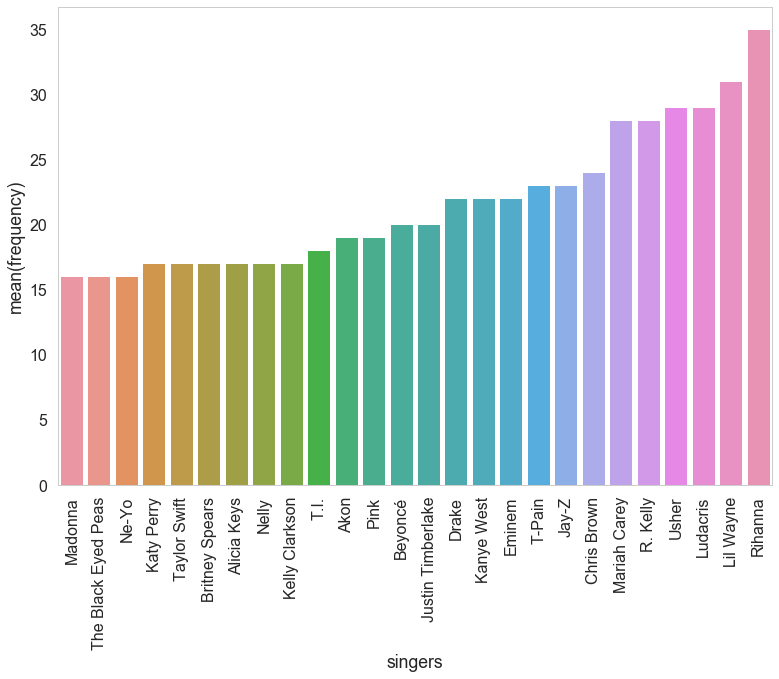

In [104]:
vals = df.band_singer.value_counts()
vals = vals[vals>15]
xx = np.array([[vals.index]])
yy = np.array([[vals.values]])
chars = pd.DataFrame(np.c_[xx[0,0,:],yy[0,0,:]],columns = ['singers','frequency'])
chars = chars.sort('frequency',ascending = True)
plt.figure()
sns.barplot(x='singers',y='frequency',data = chars)
plt.xticks(rotation = 90)
plt.grid(False)


#### 1.6 What if we used a different metric?

What we would like to capture is this: a singer should to be scored higher if the singer appears higher in the rankings. So we'd say that a singer who appeared once at a higher and once at a lower ranking is a "higher quality" singer than one who appeared twice at a lower ranking. 

To do this, group all of a singers songs together and assign each song a score `101 - ranking`. Order the singers by their total score and make a bar chart for the top 20.


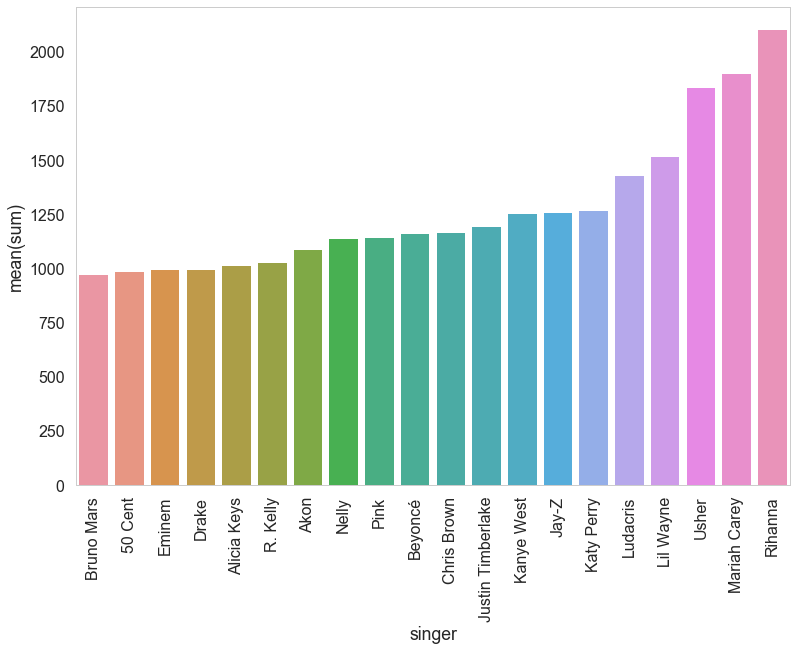

In [105]:
df['score'] = 101- df['ranking']
grouped = df.groupby('band_singer')
zz = grouped['score'].agg([np.sum])
za = zz.sort_values('sum')
zz = za.tail(20)
gpl = pd.DataFrame(np.c_[zz.index,zz.values],columns=['singer','sum'])
plt.figure()
sns.barplot(x='singer',y='sum',data = gpl)
plt.xticks(rotation = 90)
plt.grid(False)


#### 1.7 Do you notice any major differences when you change the metric?

How have the singers at the top shifted places? Why do you think this happens?

<font color = 'green'> I notice that Mariah moved up from 6th place to 2nd showing that the second metric reflects well on her. Something similar also happens between Usher and Lil Wayne. This is a classical case of quality versus quantity. Some artists release a lot of music that is able to get onto the charts but it doesn't necessarily mean their songs are at the top of the charts. The second measure (score) seems to better account for quality as opposed to simply counting the number of times a name is listed

## Q2. Scraping and Constructing: Information about Artists, Bands and Genres from Wikipedia

Our next job is to use those band/singer urls we collected under `flatframe.url` and get information about singers and/or bands.

### Scrape information about artists from wikipedia

We wish to fetch information about the singers or groups for all the winning songs in a list of years.

Here we show a function that fetches information about a singer or group from their url on wikipedia. We create a cache object `urlcache` that will avoid redundant HTTP requests (e.g. an artist might have multiple singles on a single year, or be on the list over a span of years). Once we have fetched information about an artist, we don't need to do it again. The caching also helps if the network goes down, or the target website is having some problems. You simply need to run the `get_page` function below again, and the `urlcache` dictionary will continue to be filled.

If the request gets an HTTP return code different from 200, (such as a 404 not found or 500 Internal Server Error) the cells for that URL will have a value of 1; and if the request completely fails (e.g. no network connection) the cell will have a value of 2. This will allow you to analyse the failed requests.

Notice that we have wrapped the call in whats called _an exception block_. We try to make the request. If it fails entirely, or returns a HTTP code thats not 200, we set the status to 2 and 1 respectively.

In [106]:
urlcache={}


In [107]:
def get_page(url):
    
    if url != None:
        # Check if URL has already been visited.
        if (url not in urlcache) or (urlcache[url]==1) or (urlcache[url]==2) :
            time.sleep(0.01)
            # try/except blocks are used whenever the code could generate an exception (e.g. division by zero).
            # In this case we don't know if the page really exists, or even if it does, if we'll be able to reach it.
            try:
                r = requests.get("http://en.wikipedia.org%s" % url)

                if r.status_code == 200:
                    urlcache[url] = r.text
                else:
                    urlcache[url] = 1
            except:
                urlcache[url] = 2
    else:
        urlcache[url] = None
    return urlcache[url]


We sort the `flatframe` by year, ascending, first. Think why.

In [108]:
flatframe=flatframe.sort_values('year')
flatframe.head()

,year,band_singer,ranking,song,songurl,url,score
105,1992,Bonnie Raitt,100.0,I Can't Make You Love Me,/wiki/I_Can%27t_Make_You_Love_Me,/wiki/Bonnie_Raitt,1.0
70,1992,Kris Kross,65.0,Warm It Up,/wiki/Warm_It_Up,/wiki/Kris_Kross,36.0
69,1992,Peabo Bryson,64.0,Beauty and the Beast,/wiki/Beauty_and_the_Beast_(Disney_song),/wiki/Peabo_Bryson,37.0
68,1992,Celine Dion,64.0,Beauty and the Beast,/wiki/Beauty_and_the_Beast_(Disney_song),/wiki/Celine_Dion,37.0
67,1992,Karyn White,63.0,The Way I Feel About You,None,/wiki/Karyn_White,38.0


#### Pulling and saving the data

In [109]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
# Here we are populating the url cache
# subsequent calls to this cell should be very fast, since Python won't
# need to fetch the page from the web server.
# NOTE this function will take quite some time to run (about 30 mins for me), since we sleep 1 second before
# making a request. If you run it again it will be almost instantaneous, save requests that might have failed
# (you will need to run it again if requests fail..see cell below for how to test this)
flatframe["url"].apply(get_page)

105     <!DOCTYPE html>\n<html class="client-nojs" lan...
70      <!DOCTYPE html>\n<html class="client-nojs" lan...
69      <!DOCTYPE html>\n<html class="client-nojs" lan...
68      <!DOCTYPE html>\n<html class="client-nojs" lan...
67      <!DOCTYPE html>\n<html class="client-nojs" lan...
66      <!DOCTYPE html>\n<html class="client-nojs" lan...
8       <!DOCTYPE html>\n<html class="client-nojs" lan...
65      <!DOCTYPE html>\n<html class="client-nojs" lan...
64      <!DOCTYPE html>\n<html class="client-nojs" lan...
63      <!DOCTYPE html>\n<html class="client-nojs" lan...
9       <!DOCTYPE html>\n<html class="client-nojs" lan...
62      <!DOCTYPE html>\n<html class="client-nojs" lan...
102     <!DOCTYPE html>\n<html class="client-nojs" lan...
61      <!DOCTYPE html>\n<html class="client-nojs" lan...
60      <!DOCTYPE html>\n<html class="client-nojs" lan...
10      <!DOCTYPE html>\n<html class="client-nojs" lan...
59      <!DOCTYPE html>\n<html class="client-nojs" lan...
58      <!DOCT

You may have to run this function again and again, in case there were network problems. Note that, because there is a "global" cache, it will take less time each time you run it. Also note that this function is designed to be run again and again: it attempts to make sure that there are no unresolved pages remaining. Let us make sure of this: *the sum below should be 0, and the boolean True.*

In [110]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
print("Number of bad requests:",np.sum([(urlcache[k]==1) or (urlcache[k]==2) for k in urlcache])) # no one or 0's)
print("Did we get all urls?", len(flatframe.url.unique())==len(urlcache)) # we got all of the urls

Number of bad requests: 0
Did we get all urls? True


<font color = 'green'> When I ran this previously I obtained 1 bad request - to fix this I found the song causing this issue and realized it was 1 exception (the one listed below). So to deal with it, I edited the code in get_page(url) and inserted an if condition. When it hits the null url, it sets the urlcache[various artists] = None

In [111]:
df.loc[df['url'].isnull()]

,year,band_singer,ranking,song,songurl,url,score
642,1997,Various Artists,72.0,The Jock Jam,/wiki/Jock_Jam,None,29.0


Let's save the `urlcache` to disk, just in case we need it again.

In [112]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
with open("data/artistinfo.json","w") as fd:
    json.dump(urlcache, fd)
del urlcache

In [4]:
# RERUN WHEN SUBMITTING
with open("data/artistinfo.json") as json_file:
    urlcache = json.load(json_file)

#### 2.1 Extract information about singers and bands

From each page we collected about a singer or a band, extract the following information:

1. If the page has the text "Born" in the sidebar on the right, extract the element with the class `.bday`. If the page doesn't contain "Born", store `False`.  Store either of these into the variable `born`. We want to analyze the artist's age.

2. If the text "Years active" is found, but no "born", assume a band. Store into the variable `ya` the value of the next table cell corresponding to this, or `False` if the text is not found.

Put this all into a function `singer_band_info` which takes the singer/band url as argument and returns a dictionary `dict(url=url, born=born, ya=ya)`.

The information can be found on the sidebar on each such wikipedia page, as the example here shows:

![sandg](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/sandg.png).



Write the function `singer_band_info` according to the following specification:

In [116]:
"""
Function
--------
singer_band_info

Inputs
------
url: the url
page_text: the text associated with the url
   
Returns
-------
A dictionary with the following data:
    url: copy the input argument url into this value
    born: the artist's birthday
    ya: years active variable

Notes
-----
See description above. Also note that some of the genres urls might require a 
bit of care and special handling.
"""
import requests
import re
from bs4 import BeautifulSoup
ctr = 0
def singer_band_info(url,page_text):
    c = page_text
    if c != None or []:
        soup = BeautifulSoup(c,"lxml")
        tables = soup.find_all('table')
        xr = None
        yr = None
# Being thorough in my search of the tables
        for i in range(len(tables)):
            #if (tables[i].find('span',{'class':'bday'}) != None or []) and (xr == None):
            if (tables[i].find('th',text = re.compile('Born')) != None or []) and (xr == None):
                
                xr = tables[i]
    
            elif (tables[i].find('th',text = re.compile('Years active')) != None or []) and (yr == None):
                yr = tables[i]
            
        if (xr != None or []) and (xr.find('span',{'class':'bday'}) != None or []):
            born = xr.find('span',{'class':'bday'}).getText()
            ya = False
        else:
            born = False
            if  (yr != None or []) and (yr.find('th',text=re.compile('Years active')).find_next_sibling('td') != None):
                ya = yr.find('th',text=re.compile('Years active')).find_next_sibling('td').getText()
            else:
                ya = False

        A = {'url': url, 'born':born, 'ya' : ya}
    else:
        A = {'url': url, 'born':False, 'ya' : False}
    return A

In [117]:
newdf = pd.DataFrame(columns = {'url','born','ya'})
newdf = newdf[['url','born','ya']]

for k in urlcache:
    xx = singer_band_info(k,urlcache[k])
    newdf.loc[len(newdf)] = [xx['url'],xx['born'],xx['ya']]    


In [118]:
newdf

,url,born,ya
0,/wiki/Bonnie_Raitt,1949-11-08,False
1,/wiki/Kris_Kross,False,1991–2002\n2013 (reunion)
2,/wiki/Peabo_Bryson,1951-04-13,False
3,/wiki/Celine_Dion,1968-03-30,False
4,/wiki/Karyn_White,1965-10-14,False
5,/wiki/Genesis_(band),False,\n\n\n1967–1998[4][5]\n2006–2007\n\n\n
6,/wiki/Color_Me_Badd,False,1985 (1985)–1998\n2010–present
7,/wiki/CeCe_Peniston,1969-09-06,False
8,/wiki/U2,False,1976–present
9,/wiki/The_Heights_(TV_series),False,False


#### 2.2  Merging this information in

Iterate over the items in the singer-group dictionary cache `urlcache`, run the above function, and create a dataframe from there with columns `url`, `born`, and `ya`. Merge this dataframe on the `url` key with `flatframe`, creating a rather wide dataframe that we shall call `largedf`. It should look something like this:

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC3.png)

Notice how the `born` and `ya` and `url` are repeated every time a different song from a given band is represented in a row.

In [119]:
largedf = pd.merge(df,newdf,on = 'url')
largedf

,year,band_singer,ranking,song,songurl,url,score,born,ya
0,2014,Pharrell Williams,1.0,Happy,/wiki/Happy_(Pharrell_Williams_song),/wiki/Pharrell_Williams,100.0,1973-04-05,False
1,2013,Pharrell Williams,2.0,Blurred Lines,/wiki/Blurred_Lines,/wiki/Pharrell_Williams,99.0,1973-04-05,False
2,2013,Pharrell Williams,14.0,Get Lucky,/wiki/Get_Lucky_(Daft_Punk_song),/wiki/Pharrell_Williams,87.0,1973-04-05,False
3,2005,Pharrell,23.0,Drop It Like It's Hot,/wiki/Drop_It_Like_It%27s_Hot,/wiki/Pharrell_Williams,78.0,1973-04-05,False
4,2003,Pharrell,34.0,Frontin',/wiki/Frontin%27,/wiki/Pharrell_Williams,67.0,1973-04-05,False
5,2006,Pharrell,35.0,Money Maker,/wiki/Money_Maker,/wiki/Pharrell_Williams,66.0,1973-04-05,False
6,2003,Pharrell,42.0,Beautiful,/wiki/Beautiful_(Snoop_Dogg_song),/wiki/Pharrell_Williams,59.0,1973-04-05,False
7,2002,Pharrell,62.0,"Pass the Courvoisier, Part II","/wiki/Pass_the_Courvoisier,_Part_II",/wiki/Pharrell_Williams,39.0,1973-04-05,False
8,2004,Pharrell,71.0,Drop It Like It's Hot,/wiki/Drop_It_Like_It%27s_Hot,/wiki/Pharrell_Williams,30.0,1973-04-05,False
9,2014,Pharrell Williams,83.0,Blurred Lines,/wiki/Blurred_Lines,/wiki/Pharrell_Williams,18.0,1973-04-05,False


#### 2.3 What is the age at which singers achieve their top ranking?

Plot a histogram of the age at which singers achieve their top ranking. What conclusions can you draw from this distribution of ages?

*HINT: You will need to do some manipulation of the `born` column, and find the song for which a band or an artist achieves their top ranking. You will then need to put these rows together into another dataframe or array to make the plot.*

In [120]:
pd.options.mode.chained_assignment = None 
xq = largedf.loc[largedf['born'] != False]
xq['score'] = 101 - xq['ranking']
xq['byear'] = xq['born'].str[0:4]
xq['byear'] = xq.byear.astype(int)
xq['age'] = xq['year'] -xq['byear']

In [122]:
agehistdata = xq.groupby('band_singer').agg({'score':'max', 'age':'first'})

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


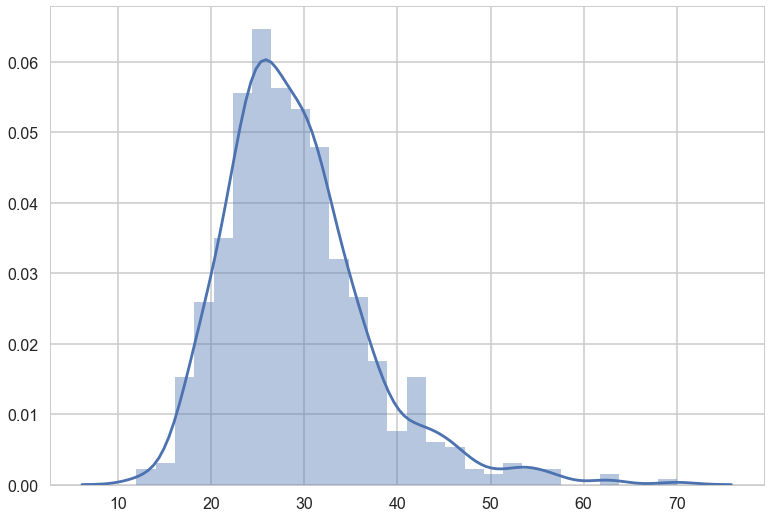

In [123]:
sns.distplot(agehistdata['age'].values)

#### 2.4 At what year since inception do bands reach their top rankings?

Make a similar calculation to plot a histogram of the years since inception at which bands reach their top ranking. What conclusions can you draw?

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


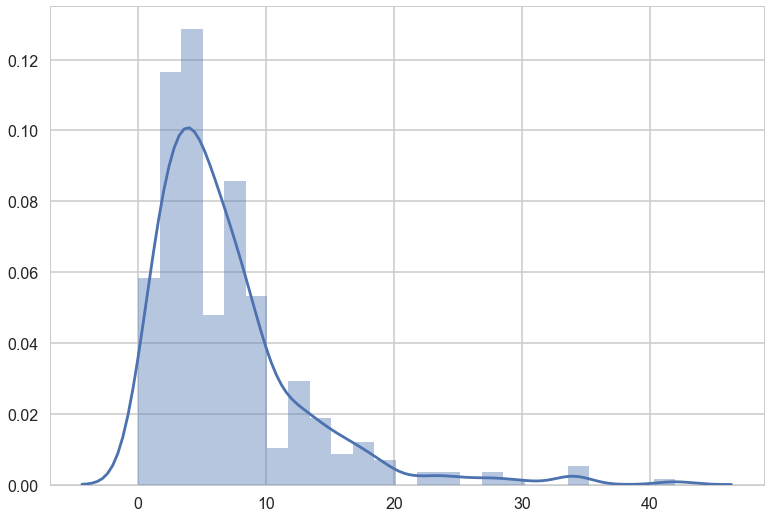

In [135]:
xa = largedf.loc[largedf['ya'] != False]
xa['score'] = 101 - xa['ranking']
xa['byear'] = xa['ya'].str[0:4]
xa['byear'] = xa.byear.astype(int)
xa['age'] = xa['year'] -xa['byear']
xa = xa[xa['age']<100]
bandagehistdata = xa.groupby('band_singer').agg({'score':'max', 'age':'first'})
sns.distplot(bandagehistdata['age'].values)

<font color = 'green'> We can see from the figures above that bands usually attain their highest score in the early stages of their founding. We find that individual artists usually achieve their highest ranking song in their mid to late 20's. While individual singers achieve their score in this range, the variance in age is larger than the variance in the age of a band 